In [1]:
import pandas as pd
import numpy as np
import panel as pn
import folium as fm
import param
pn.extension('tabulator')
pn.extension(sizing_mode="stretch_width")
import hvplot.pandas

In [2]:
# df = pd.read_csv("https://raw.githubusercontent.com/owid/co2-data/master/owid-co2-data.csv")

In [3]:
 #df = pd.read_csv("https://raw.githubusercontent.com/oneon/firedataset/main/ts_active_fire_shape_24h.csv")

In [3]:
# cache data to improve dashboard performance
if 'data' not in pn.state.cache.keys():

    df = pd.read_csv('https://raw.githubusercontent.com/owid/co2-data/master/owid-co2-data.csv')

    pn.state.cache['data'] = df.copy()

else: 

    df = pn.state.cache['data']

In [4]:
df

,latitude,longitude,acq_date,acq_time,satellite,instrument,year,month,week,Mandal_Nam,Dist_Name,confidence
0,16.05964,78.53480,2023-02-12,800,N,VIIRS,2023,2,6,Kollapur,Nagarkurnool,50
1,16.06020,78.53841,2023-02-12,800,N,VIIRS,2023,2,6,Kollapur,Nagarkurnool,50
2,16.06033,78.53378,2023-02-12,847,1,VIIRS,2023,2,6,Kollapur,Nagarkurnool,50
3,16.06080,78.53876,2023-02-12,847,1,VIIRS,2023,2,6,Kollapur,Nagarkurnool,50
4,16.06185,78.52681,2023-02-12,839,A,MODIS,2023,2,6,Kollapur,Nagarkurnool,58
...,...,...,...,...,...,...,...,...,...,...,...,...
434,19.55790,78.58727,2023-02-11,2050,N,VIIRS,2023,2,6,Adilabad Rural,Adilabad,50
435,19.56136,78.58607,2023-02-11,2050,N,VIIRS,2023,2,6,Adilabad Rural,Adilabad,50
436,19.56225,78.58593,2023-02-11,1957,1,VIIRS,2023,2,6,Adilabad Rural,Adilabad,50
437,19.56958,78.60809,2023-02-12,800,N,VIIRS,2023,2,6,Adilabad Rural,Adilabad,50


In [5]:
df[df['country'] == 'North America']

,country,year,iso_code,population,gdp,cement_co2,cement_co2_per_capita,co2,co2_growth_abs,co2_growth_prct,...,share_global_cumulative_other_co2,share_global_flaring_co2,share_global_gas_co2,share_global_luc_co2,share_global_oil_co2,share_global_other_co2,total_ghg,total_ghg_excluding_lucf,trade_co2,trade_co2_share
30258,North America,1750,NaN,11396206.0,NaN,0.000,0.000,0.000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30259,North America,1751,NaN,NaN,NaN,0.000,NaN,0.000,0.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30260,North America,1752,NaN,NaN,NaN,0.000,NaN,0.000,0.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30261,North America,1753,NaN,NaN,NaN,0.000,NaN,0.000,0.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30262,North America,1754,NaN,NaN,NaN,0.000,NaN,0.000,0.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30525,North America,2017,NaN,581258143.0,NaN,75.813,0.131,6425.781,-47.450,-0.733,...,16.573,20.852,25.996,11.418,24.038,9.941,7418.35,7566.229,386.995,6.023
30526,North America,2018,NaN,585864285.0,NaN,74.562,0.127,6614.565,188.784,2.938,...,16.308,23.347,27.322,12.033,24.345,8.880,7630.50,7777.590,388.395,5.872
30527,North America,2019,NaN,590497015.0,NaN,75.227,0.127,6500.850,-113.715,-1.719,...,16.071,25.761,27.536,11.097,24.243,9.281,7515.65,7663.030,382.097,5.878
30528,North America,2020,NaN,594263186.0,NaN,75.718,0.127,5805.619,-695.230,-10.694,...,15.855,23.337,27.318,12.876,23.093,9.241,NaN,NaN,450.022,7.751


In [6]:
df[df['country'] == 'World']

,country,year,iso_code,population,gdp,cement_co2,cement_co2_per_capita,co2,co2_growth_abs,co2_growth_prct,...,share_global_cumulative_other_co2,share_global_flaring_co2,share_global_gas_co2,share_global_luc_co2,share_global_oil_co2,share_global_other_co2,total_ghg,total_ghg_excluding_lucf,trade_co2,trade_co2_share
45735,World,1750,NaN,7.456645e+08,NaN,NaN,NaN,9.351,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45736,World,1751,NaN,NaN,NaN,NaN,NaN,9.351,0.000,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45737,World,1752,NaN,NaN,NaN,NaN,NaN,9.354,0.004,0.039,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45738,World,1753,NaN,NaN,NaN,NaN,NaN,9.354,0.000,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45739,World,1754,NaN,NaN,NaN,NaN,NaN,9.358,0.004,0.039,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46002,World,2017,NaN,7.599822e+09,1.104307e+14,1507.923,0.198,36096.738,572.547,1.612,...,100.0,100.0,100.0,100.0,100.0,100.0,48251.879,47031.820,0.000,0.0
46003,World,2018,NaN,7.683790e+09,1.136302e+14,1569.218,0.204,36826.508,729.772,2.022,...,100.0,100.0,100.0,100.0,100.0,100.0,49368.039,47980.469,-0.004,-0.0
46004,World,2019,NaN,7.764951e+09,NaN,1617.507,0.208,37082.559,256.049,0.695,...,100.0,100.0,100.0,100.0,100.0,100.0,49758.230,48116.559,0.000,0.0
46005,World,2020,NaN,7.840953e+09,NaN,1637.537,0.209,35264.086,-1818.472,-4.904,...,100.0,100.0,100.0,100.0,100.0,100.0,NaN,NaN,0.000,0.0


## (0) Some minor data preprocessing

In [7]:
# Fill NAs with 0s and create GDP per capita column
df = df.fillna(0)
df['gdp_per_capita'] = np.where(df['population']!= 0, df['gdp']/ df['population'], 0)

In [8]:
# Make DataFrame Pipeline Interactive
idf = df.interactive()

## (1) CO2 emission over time by continent

In [9]:
# Define Panel widgets
year_slider = pn.widgets.IntSlider(name='Year slider', start=1750, end=2020, step=5, value=1850)
year_slider

IntSlider(end=2020, name='Year slider', sizing_mode='stretch_width', start=1750, step=5, value=1850)

In [10]:
# Radio buttons for CO2 measures
yaxis_co2 = pn.widgets.RadioButtonGroup(
    name='Y axis', 
    options=['co2', 'co2_per_capita',],
    button_type='success'
)

In [11]:
continents = ['World', 'Asia', 'Oceania', 'Europe', 'Africa', 'North America', 'South America', 'Antarctica']

co2_pipeline = (
    idf[
        (idf.year <= year_slider) &
        (idf.country.isin(continents))
    ]
    .groupby(['country', 'year'])[yaxis_co2].mean()
    .to_frame()
    .reset_index()
    .sort_values(by='year')  
    .reset_index(drop=True)
)

In [12]:
co2_pipeline

In [13]:
co2_plot = co2_pipeline.hvplot(x = 'year', by='country', y=yaxis_co2,line_width=2, title="CO2 emission by continent")
co2_plot

## (2) Table - CO2 emission over time by continent 

In [14]:
co2_table = co2_pipeline.pipe(pn.widgets.Tabulator, pagination='remote', page_size = 10, sizing_mode='stretch_width') 
co2_table

## (3) CO2 vs GDP scatterplot

In [15]:
co2_vs_gdp_scatterplot_pipeline = (
    idf[
        (idf.year == year_slider) &
        (~ (idf.country.isin(continents)))
    ]
    .groupby(['country', 'year', 'gdp_per_capita'])['co2'].mean()
    .to_frame()
    .reset_index()
    .sort_values(by='year')  
    .reset_index(drop=True)
)

In [16]:
co2_vs_gdp_scatterplot_pipeline

In [17]:
co2_vs_gdp_scatterplot = co2_vs_gdp_scatterplot_pipeline.hvplot(x='gdp_per_capita', 
                                                                y='co2', 
                                                                by='country', 
                                                                size=80, kind="scatter", 
                                                                alpha=0.7,
                                                                legend=False, 
                                                                height=500, 
                                                                width=500)
co2_vs_gdp_scatterplot

## (4) Bar chart with CO2 sources by continent

In [18]:
yaxis_co2_source = pn.widgets.RadioButtonGroup(
    name='Y axis', 
    options=['coal_co2', 'oil_co2', 'gas_co2'], 
    button_type='success'
)

continents_excl_world = ['Asia', 'Oceania', 'Europe', 'Africa', 'North America', 'South America', 'Antarctica']

co2_source_bar_pipeline = (
    idf[
        (idf.year == year_slider) &
        (idf.country.isin(continents_excl_world))
    ]
    .groupby(['year', 'country'])[yaxis_co2_source].sum()
    .to_frame()
    .reset_index()
    .sort_values(by='year')  
    .reset_index(drop=True)
)

In [19]:
co2_source_bar_plot = co2_source_bar_pipeline.hvplot(kind='bar', 
                                                     x='country', 
                                                     y=yaxis_co2_source, 
                                                     title='CO2 source by continent')
co2_source_bar_plot

## Creating Map

In [20]:
#pwd

In [21]:
#ls -l wildfire-data/active-data

In [22]:
#dfm = pd.read_csv('wildfire-data/active-data/ts_active_fire_shape_24h.csv')

In [5]:
dfm = pd.read_csv('https://raw.githubusercontent.com/oneon/firedataset/main/ts_active_fire_shape_24h.csv')

In [6]:
dfm = dfm[dfm['Dist_Name'].str.contains('Nalgonda') | dfm['Dist_Name'].str.contains('Nagarkurnool')]

In [7]:
dfm.shape

(21, 12)

In [8]:
def get_map(lat=16.385318, long=78.9740939, zoom_start=8):
    return fm.Map(location=[lat,long], zoom_start=zoom_start)

map = get_map()

pn.panel(map, height=400)

Folium(Map, height=400)

In [9]:
def get_df_aqi():
    aqi = dfm
    return pd.DataFrame(aqi)

df_aqi = get_df_aqi()

In [10]:
df_aqi

,latitude,longitude,acq_date,acq_time,satellite,instrument,year,month,week,Mandal_Nam,Dist_Name,confidence
0,16.05964,78.53480,2023-02-12,800,N,VIIRS,2023,2,6,Kollapur,Nagarkurnool,50
1,16.06020,78.53841,2023-02-12,800,N,VIIRS,2023,2,6,Kollapur,Nagarkurnool,50
2,16.06033,78.53378,2023-02-12,847,1,VIIRS,2023,2,6,Kollapur,Nagarkurnool,50
3,16.06080,78.53876,2023-02-12,847,1,VIIRS,2023,2,6,Kollapur,Nagarkurnool,50
4,16.06185,78.52681,2023-02-12,839,A,MODIS,2023,2,6,Kollapur,Nagarkurnool,58
5,16.06210,78.52530,2023-02-12,847,1,VIIRS,2023,2,6,Kollapur,Nagarkurnool,50
6,16.06296,78.53426,2023-02-12,800,N,VIIRS,2023,2,6,Kollapur,Nagarkurnool,50
7,16.06310,78.53513,2023-02-12,847,1,VIIRS,2023,2,6,Kollapur,Nagarkurnool,50
8,16.06353,78.53787,2023-02-12,800,N,VIIRS,2023,2,6,Kollapur,Nagarkurnool,50
9,16.06361,78.54008,2023-02-12,847,1,VIIRS,2023,2,6,Kollapur,Nagarkurnool,50


Folium(Map, height=400)
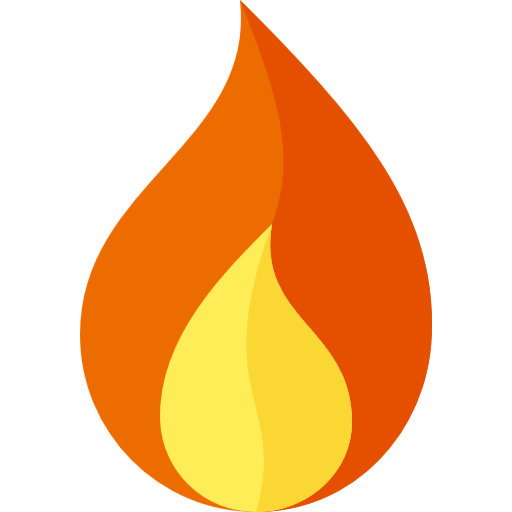
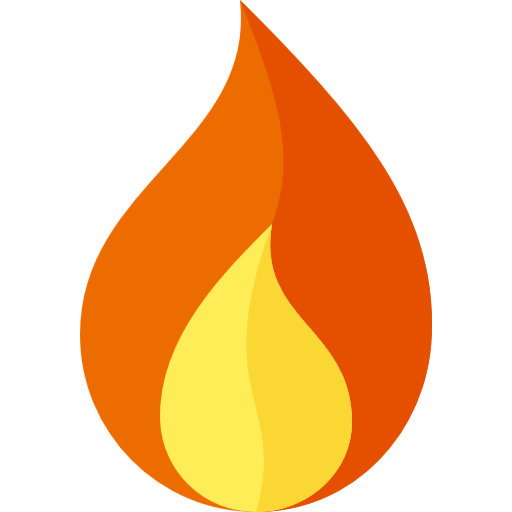
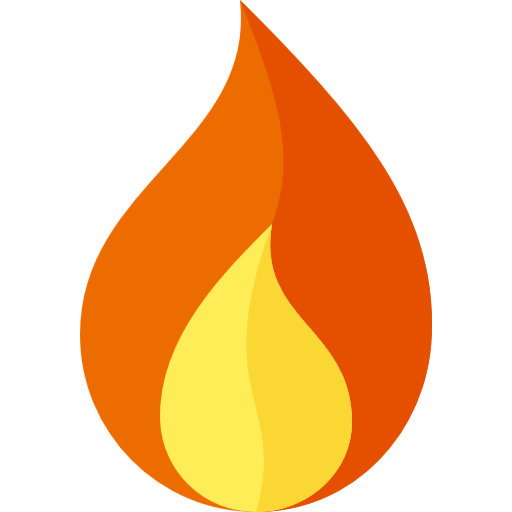
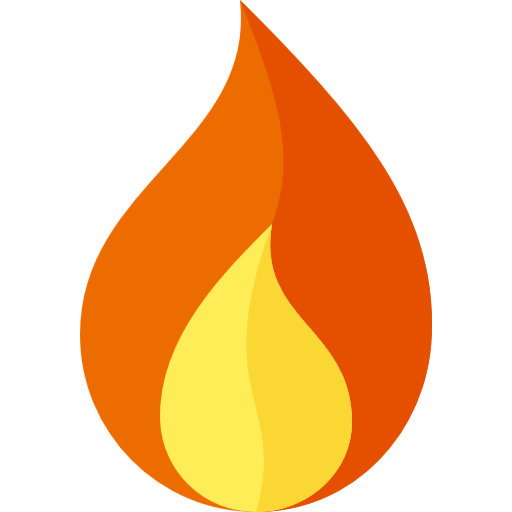
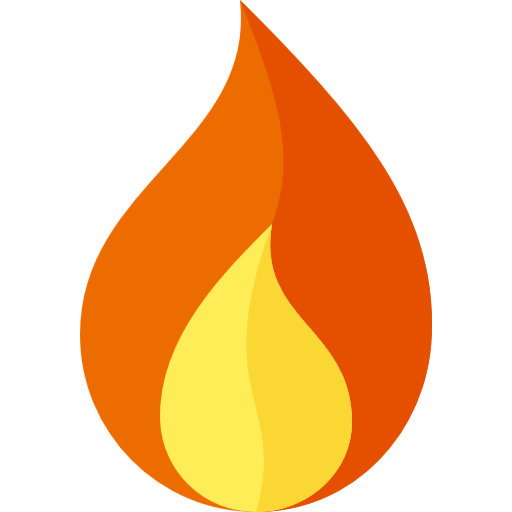
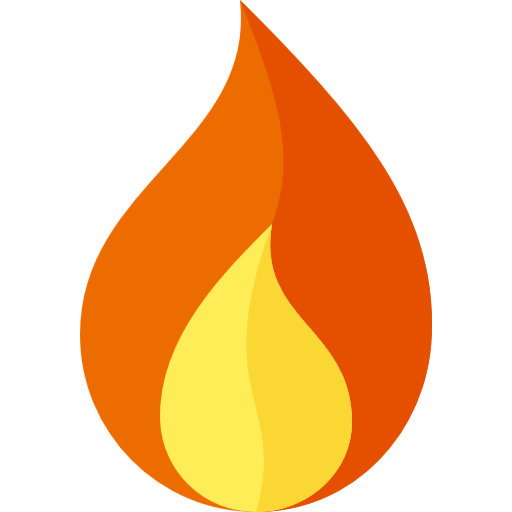
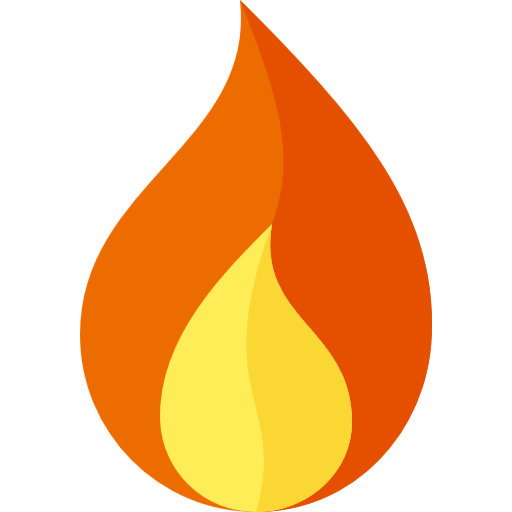
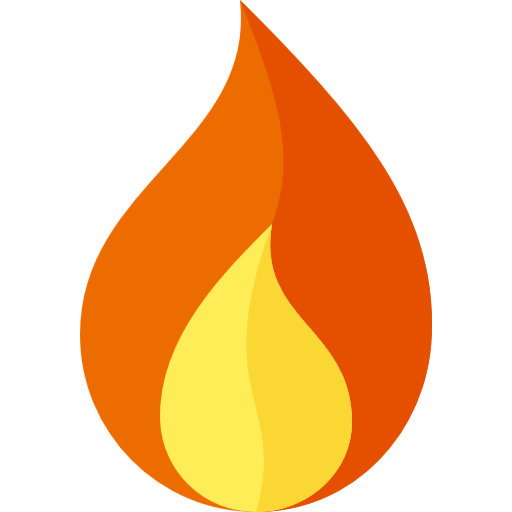
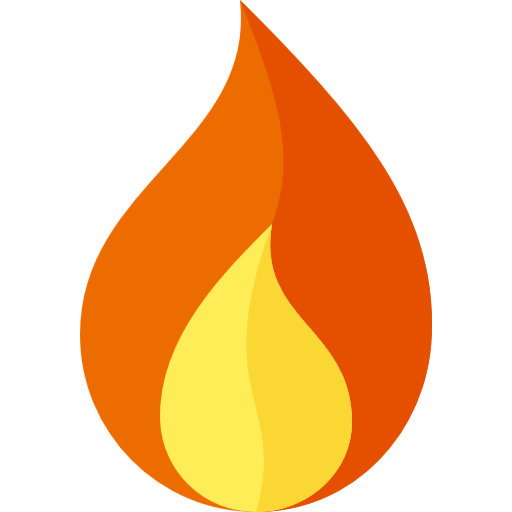
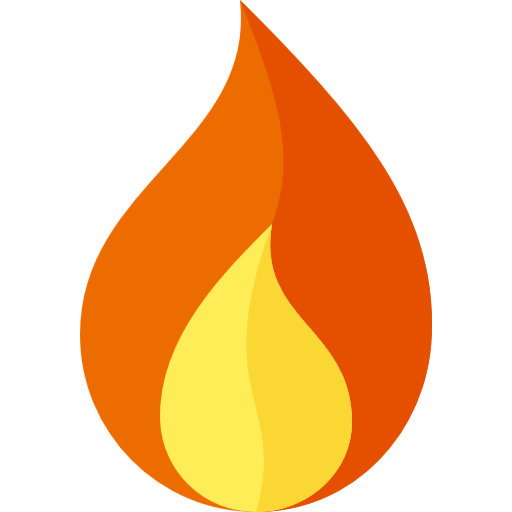
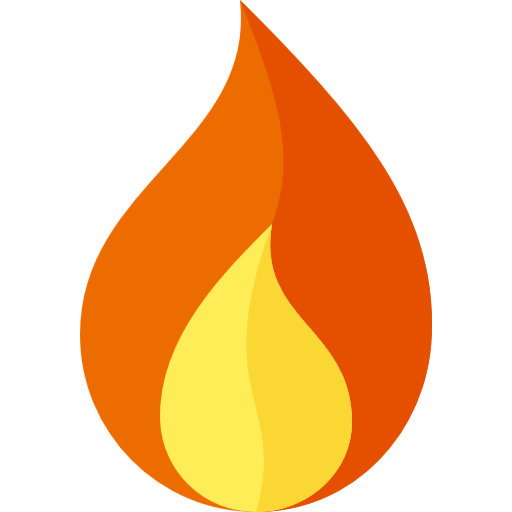
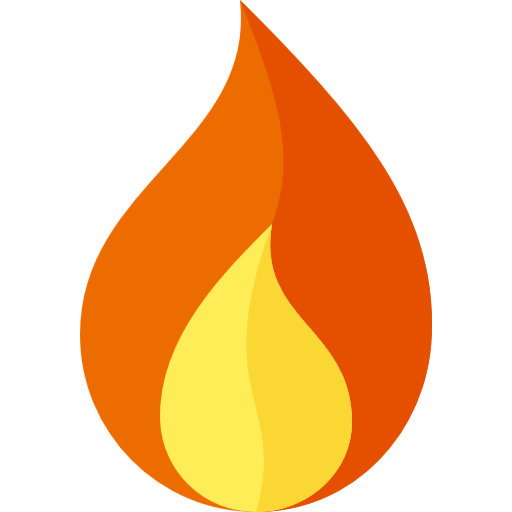
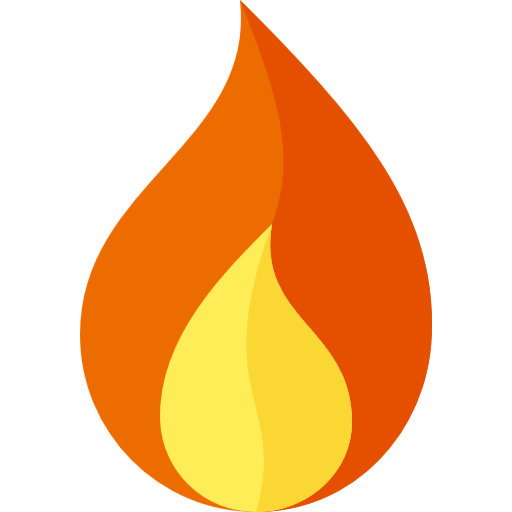
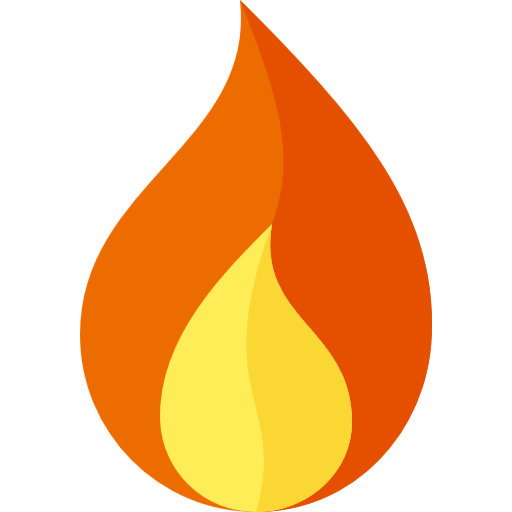
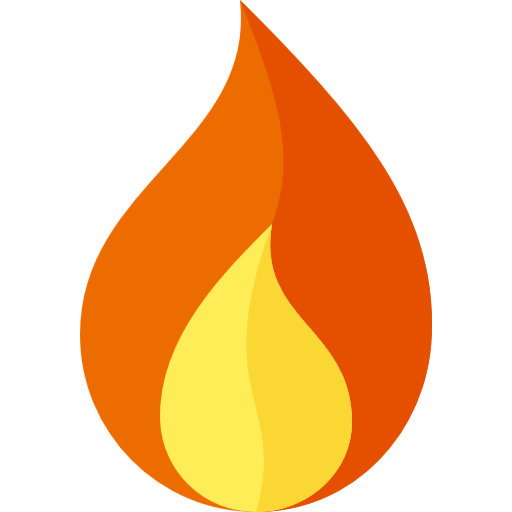
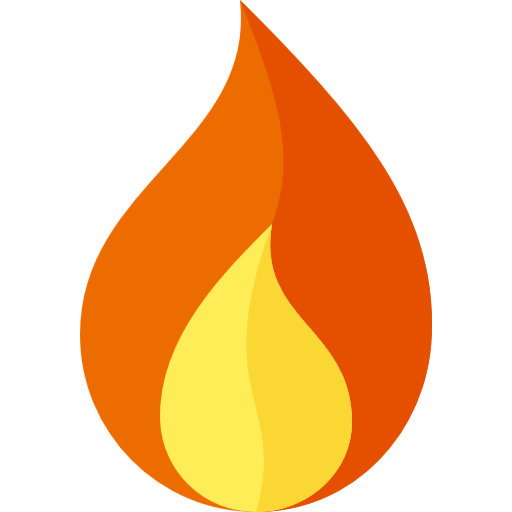
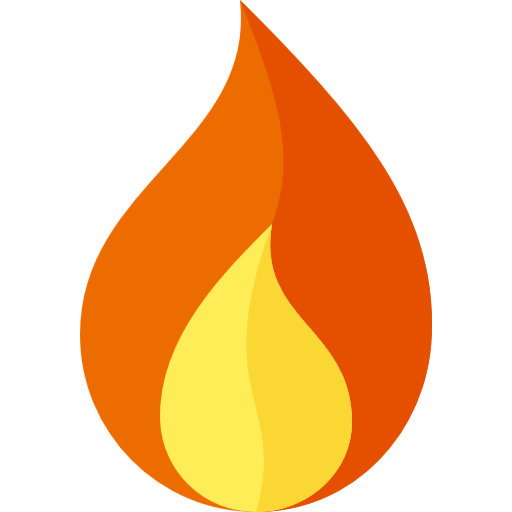
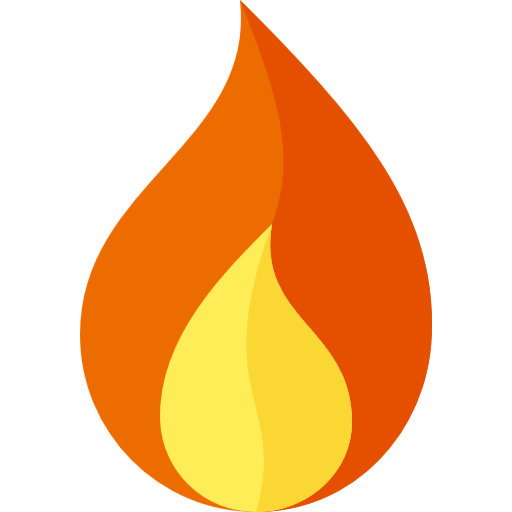
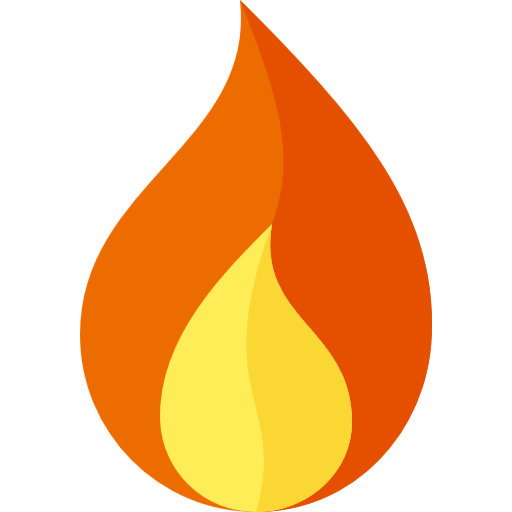
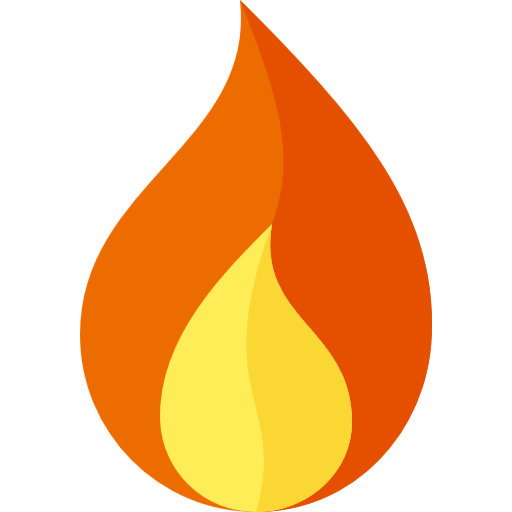
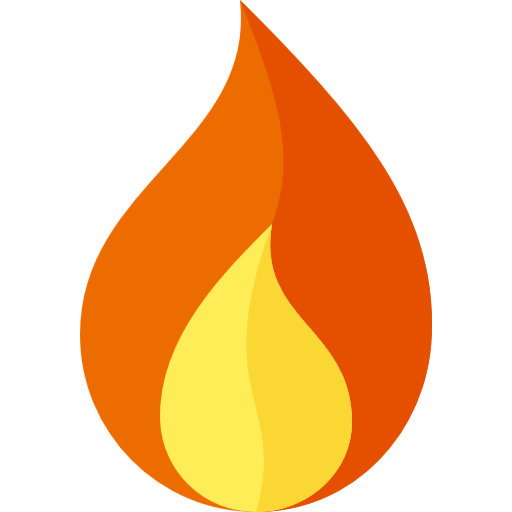

In [11]:
def add_aqi_circles(map, df_aqi):
    green_p1  = fm.map.FeatureGroup()
    yellow_p1 = fm.map.FeatureGroup()
    orange_p1 = fm.map.FeatureGroup()
    red_p1    = fm.map.FeatureGroup()
    purple_p1 = fm.map.FeatureGroup()
    maroon_p1 = fm.map.FeatureGroup()

    for _, row in df_aqi.iterrows():
        if row.confidence<10:
            feature_group = green_p1
            fill_color = "green"
        elif row.confidence < 30:
            feature_group = yellow_p1
            fill_color = "yellow"
        elif row.confidence < 50:
            feature_group = orange_p1
            fill_color = "orange"
        elif row.confidence < 70:
            feature_group = red_p1
            fill_color = "red"
        elif row.confidence < 90:
            feature_group = purple_p1
            fill_color='purple'
        else:
            feature_group = maroon_p1
            fill_color = "maroon"
    
    
        html=f"""
            <h1> {row.Dist_Name}</h1>
            <p>You can use any html here! Let's do a list:</p>
            <ul>
                <li>Week {row.week}</li>
                <li>Year {row.year}</li>
            </ul>
            </p>
            <p>And that's a <a href="https://www.python-graph-gallery.com">link</a></p>
            """
        iframe = fm.IFrame(html=html, width=200, height=200)
        popup = fm.Popup(iframe, max_width=2650)
        pushpin = fm.features.CustomIcon('fire-flame.png', icon_size=(30,30))
        feature_group.add_child(
            fm.Marker(
                [row.latitude, row.longitude],
                icon=pushpin,
                popup=popup
            )
        )

    map.add_child(green_p1)
    map.add_child(yellow_p1)
    map.add_child(orange_p1)
    map.add_child(red_p1)
    map.add_child(purple_p1)

add_aqi_circles(map, df_aqi)
pn.panel(map, height=400)

Column(height=500, sizing_mode='stretch_both')
    [0] IntSlider(end=100, name='Points count', sizing_mode='stretch_width', start=10, value=20)
    [1] Folium(Map, margin=0, min_height=500, sizing_mode='stretch_both')
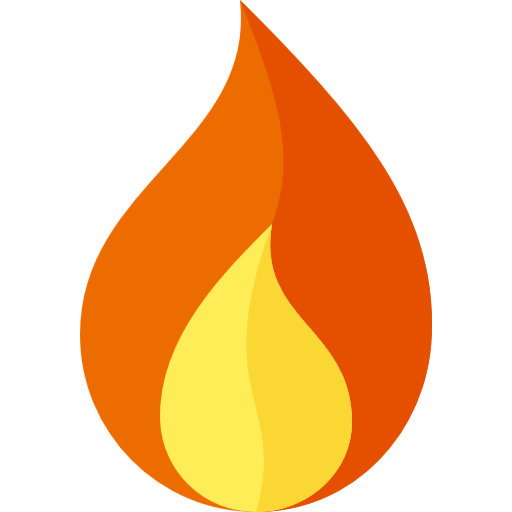
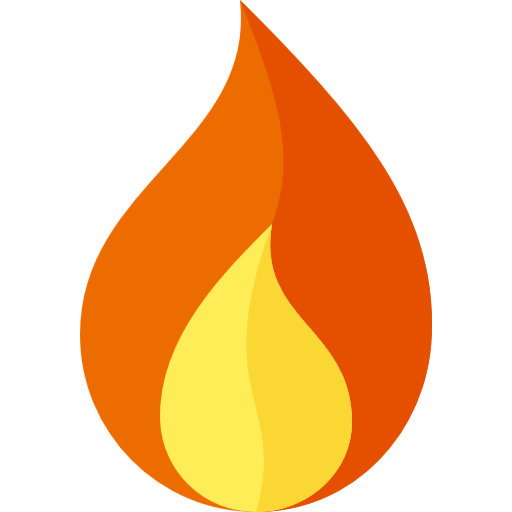
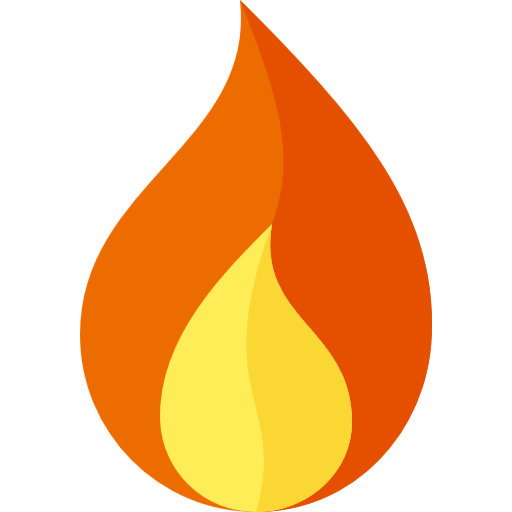
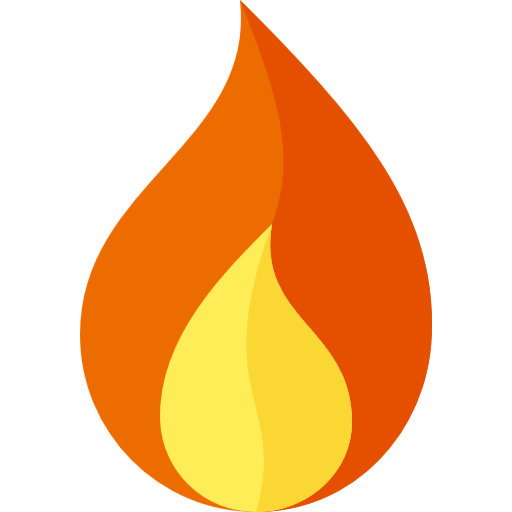
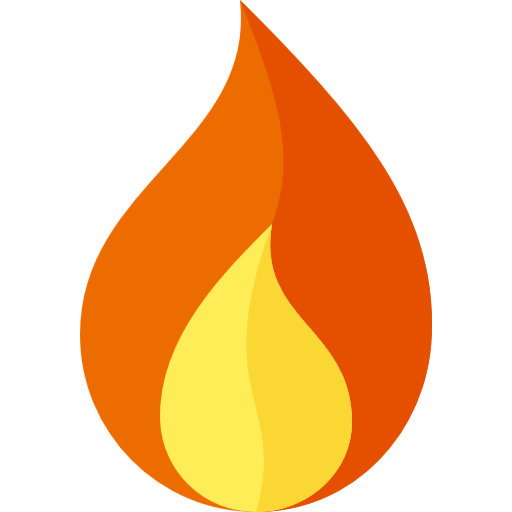
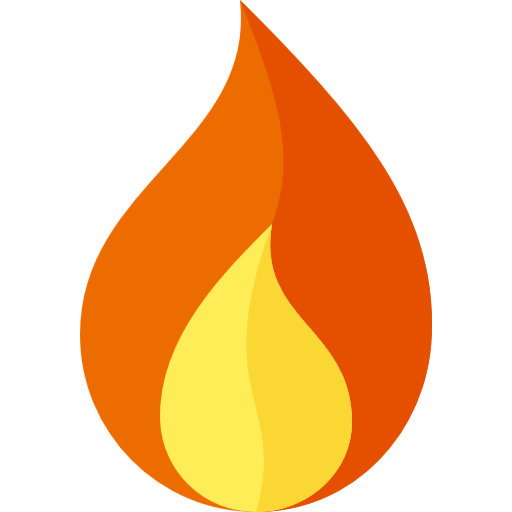
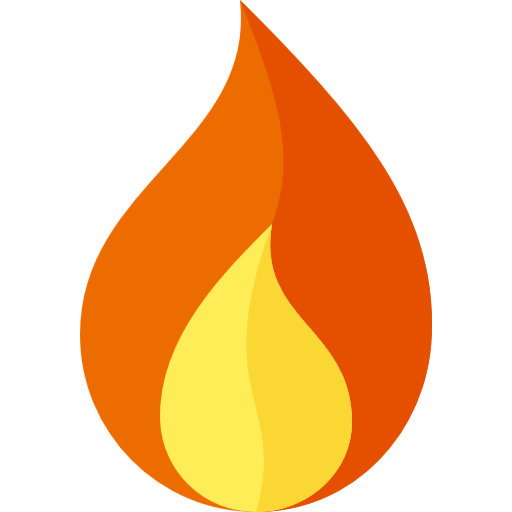
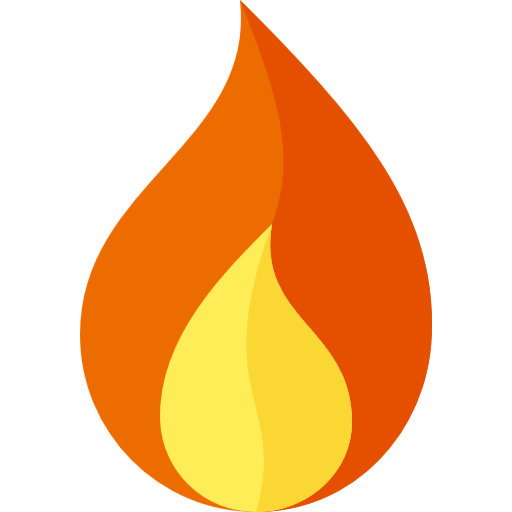
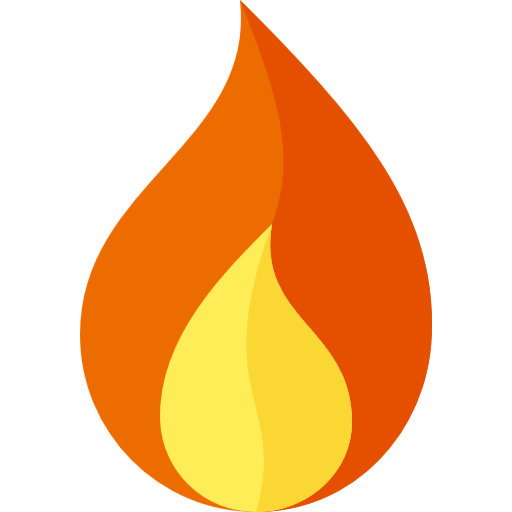
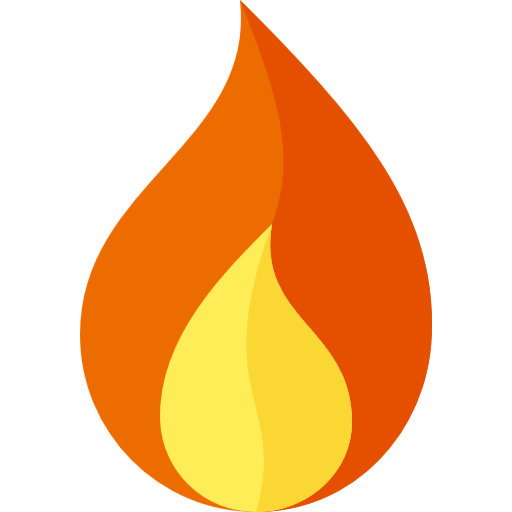
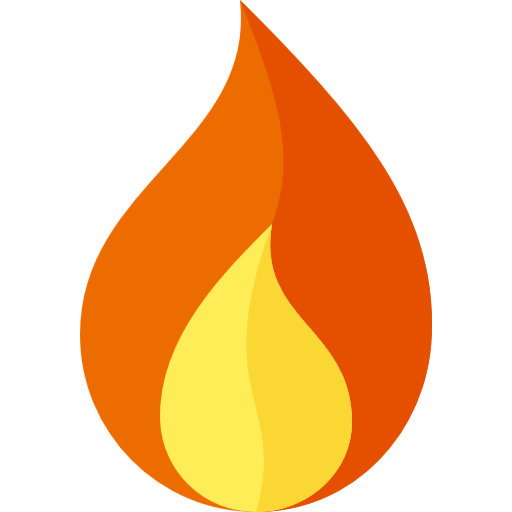
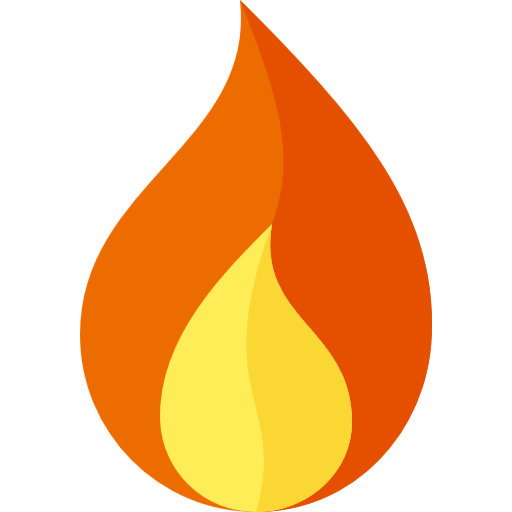
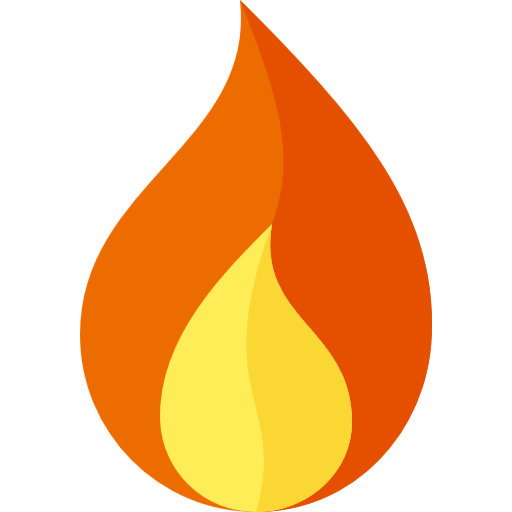
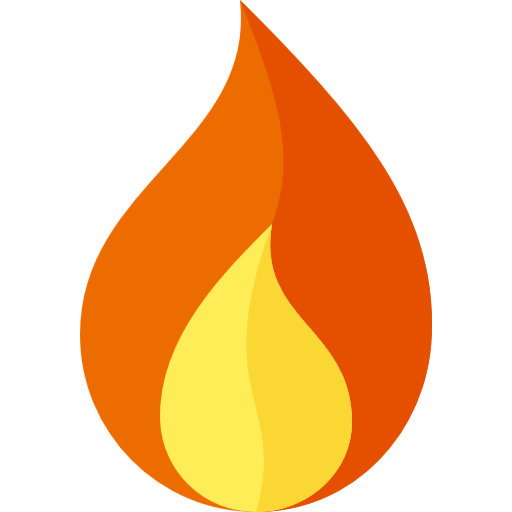
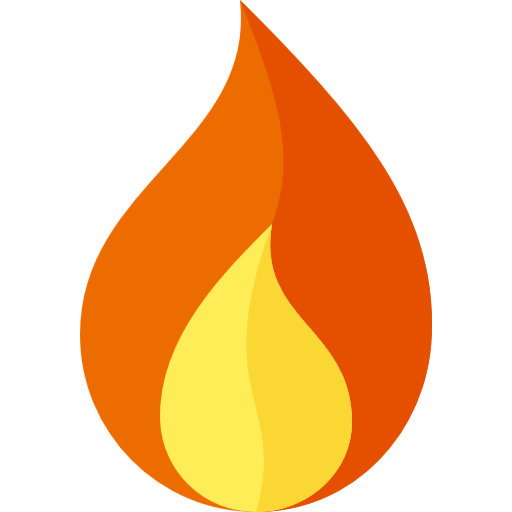
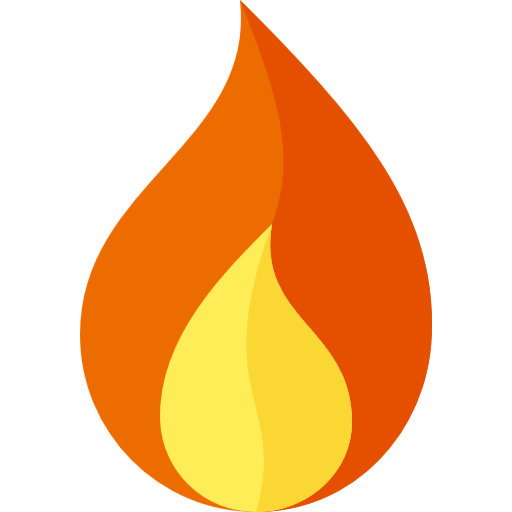
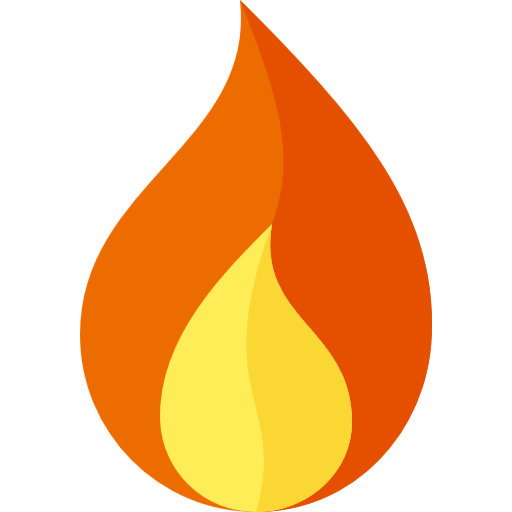
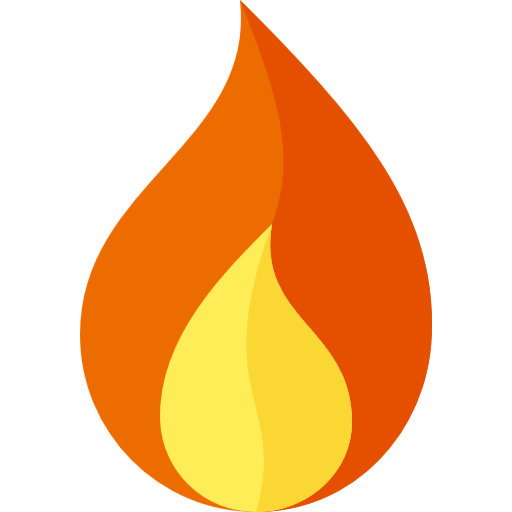
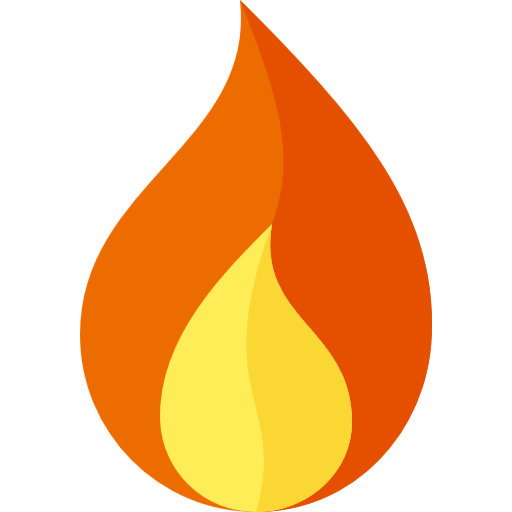
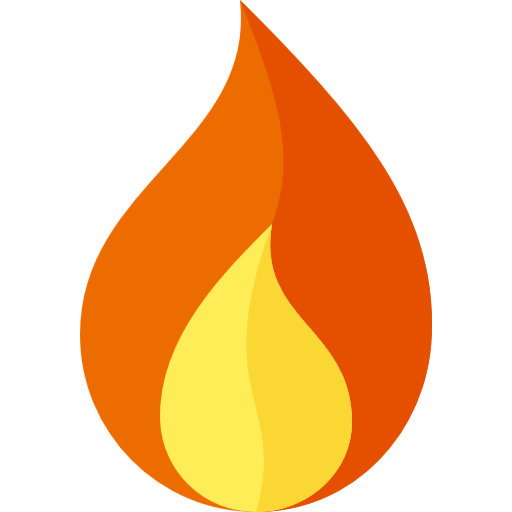
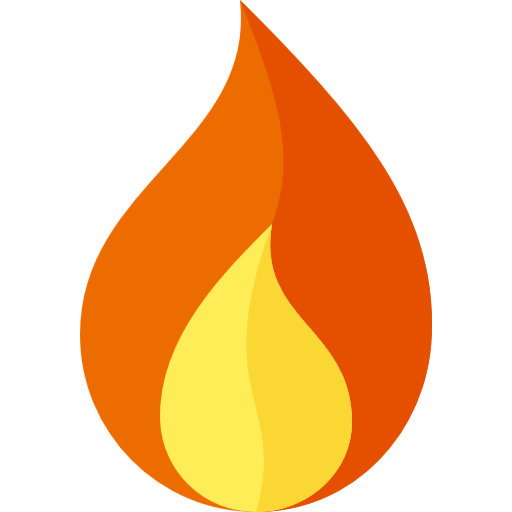

In [12]:
class PanelFoliumMap(param.Parameterized):
    points_count = param.Integer(20, bounds=(10,100))
        
    def __init__(self, **params):
        super().__init__(**params)
        self.map = get_map()
        self.folium_pane = pn.pane.plot.Folium(sizing_mode="stretch_both", min_height=500, margin=0)    
        self.view = pn.Column(
            self.param.points_count,
            self.folium_pane,
            sizing_mode="stretch_both", height=500
        )
        self._update_map()

    @param.depends("points_count", watch=True)
    def _update_map(self):
        self.map = get_map()
        df_aqi = get_df_aqi()
        add_aqi_circles(self.map, df_aqi)
        self.folium_pane.object = self.map

        
app = PanelFoliumMap()
app.view

Column(height=500, sizing_mode='stretch_both')
    [0] IntSlider(end=100, name='Points count', sizing_mode='stretch_width', start=10, value=20)
    [1] Folium(Map, margin=0, min_height=500, sizing_mode='stretch_both')
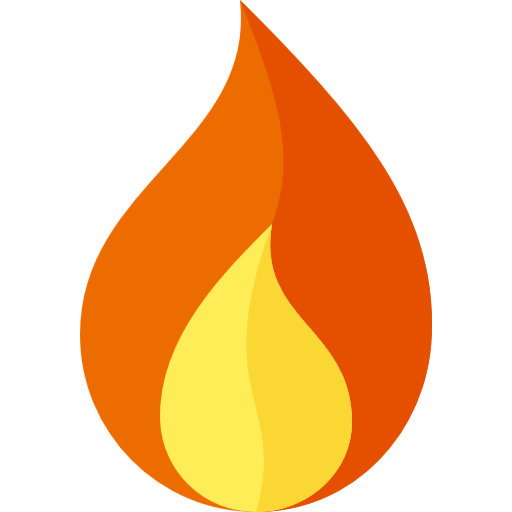
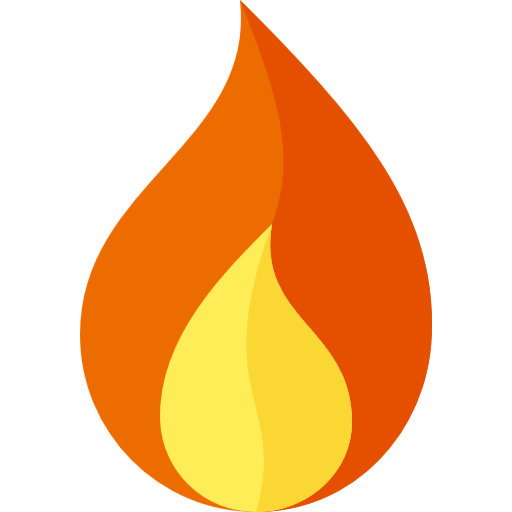
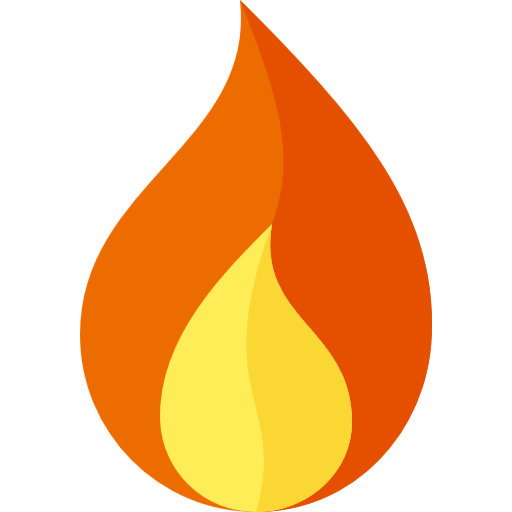
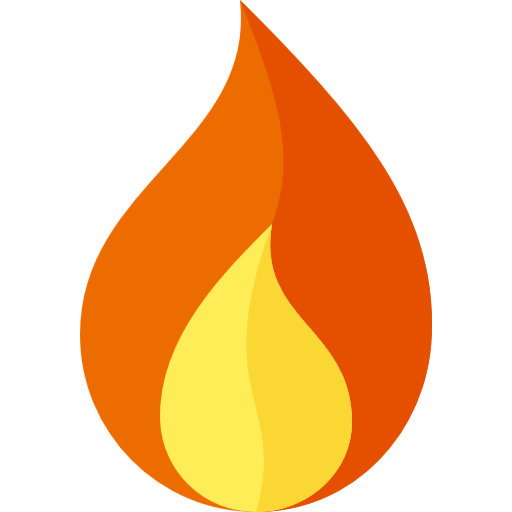
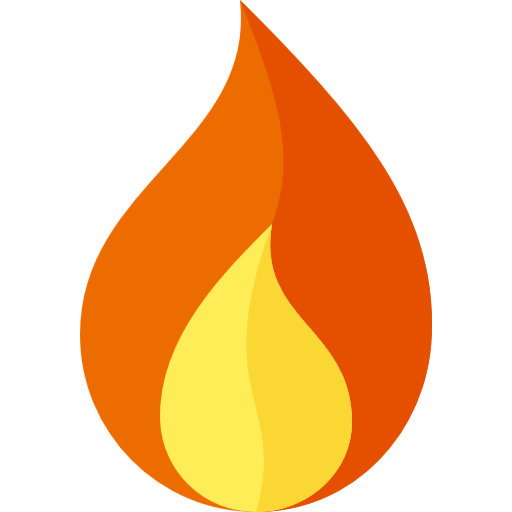
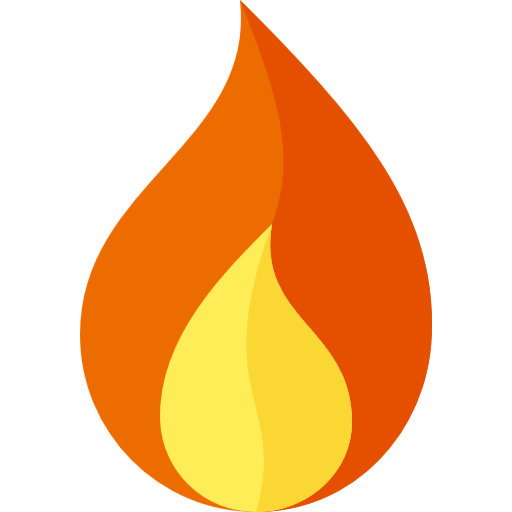
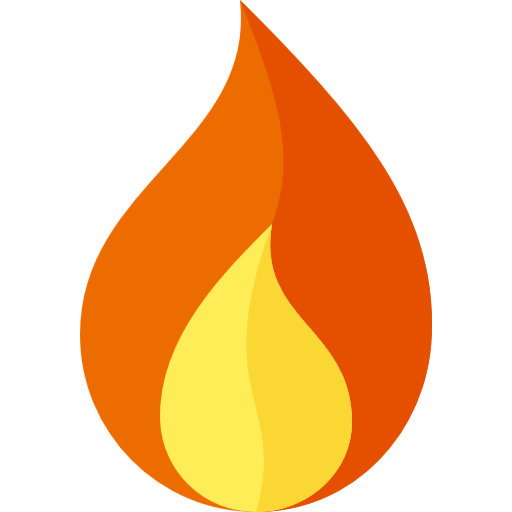
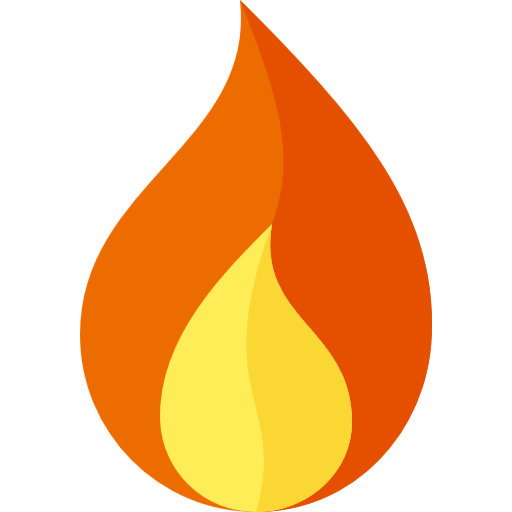
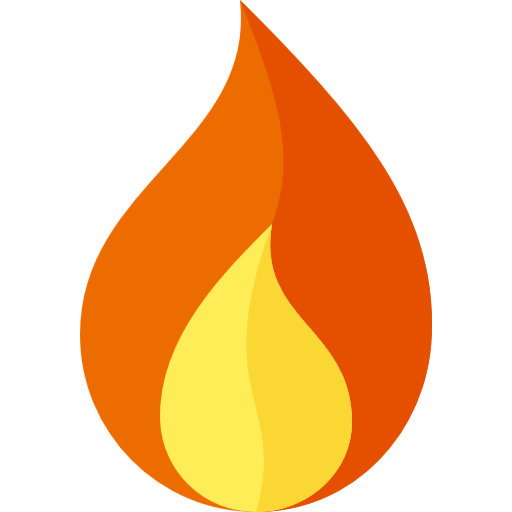
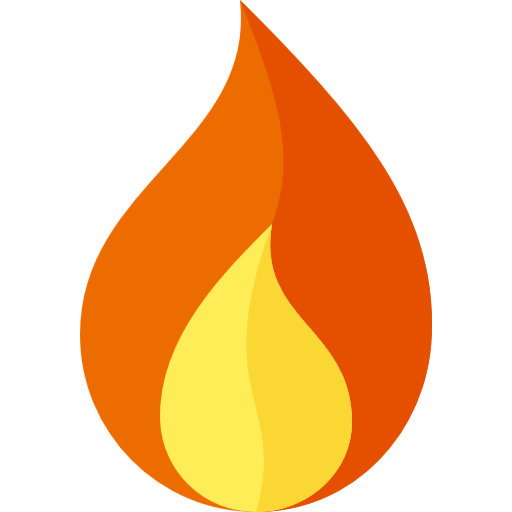
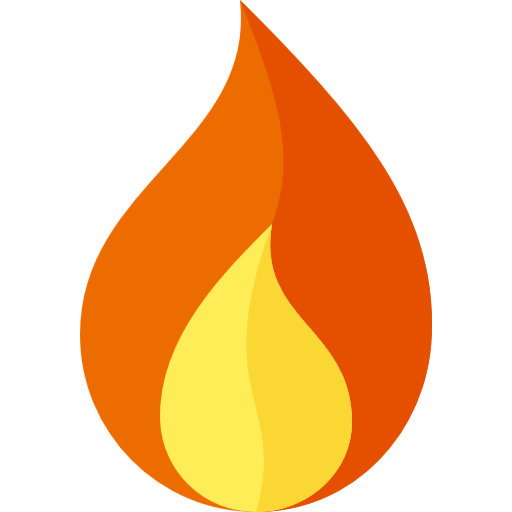
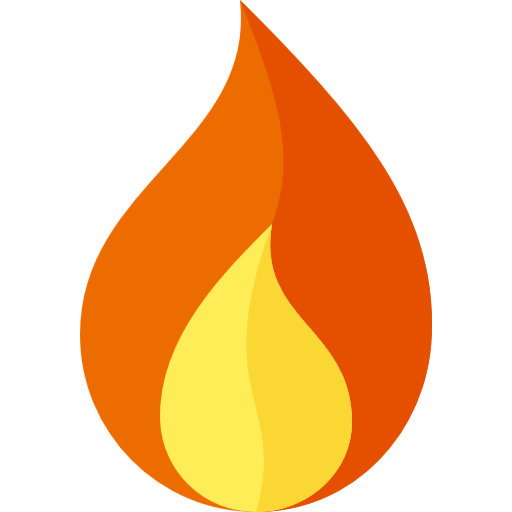
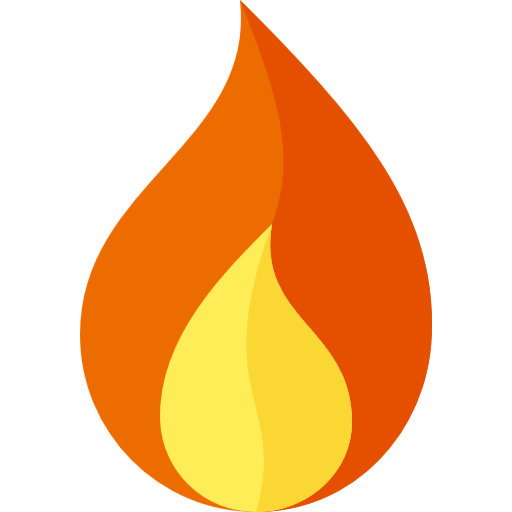
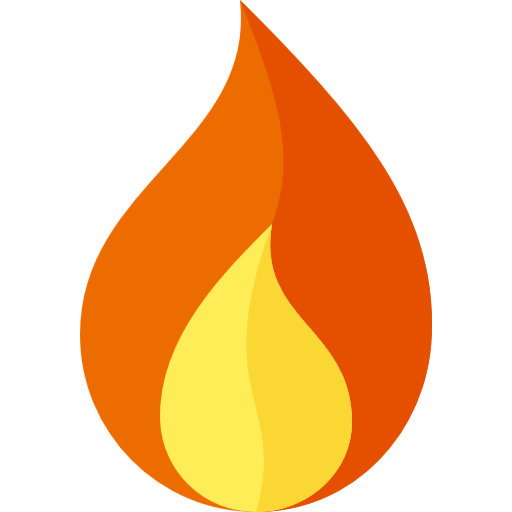
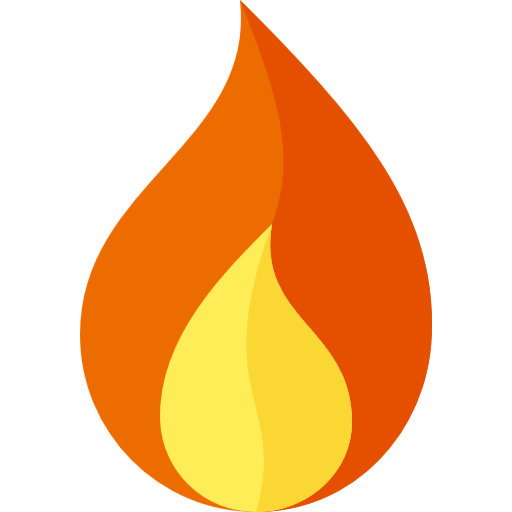
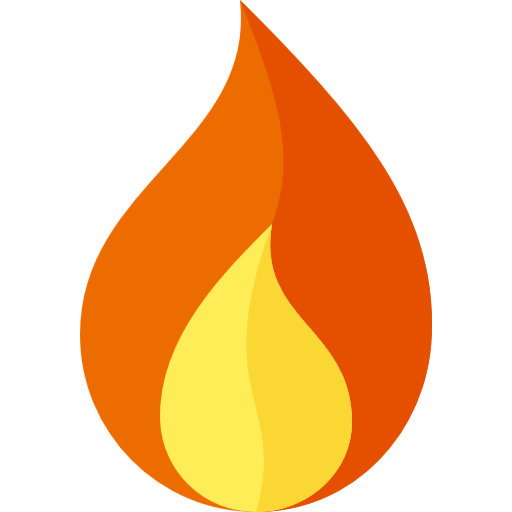
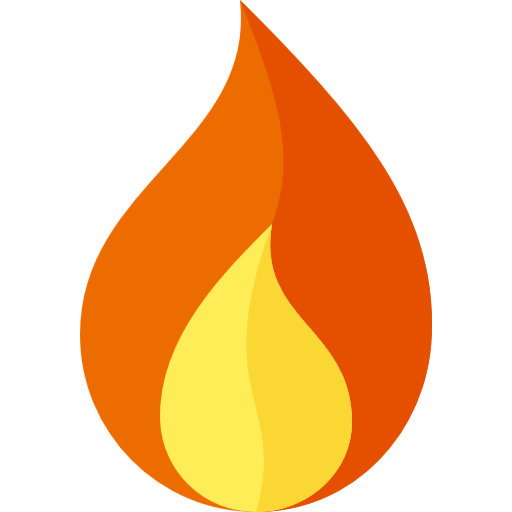
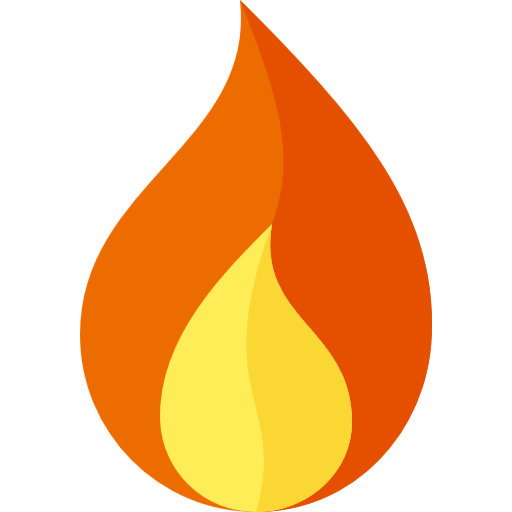
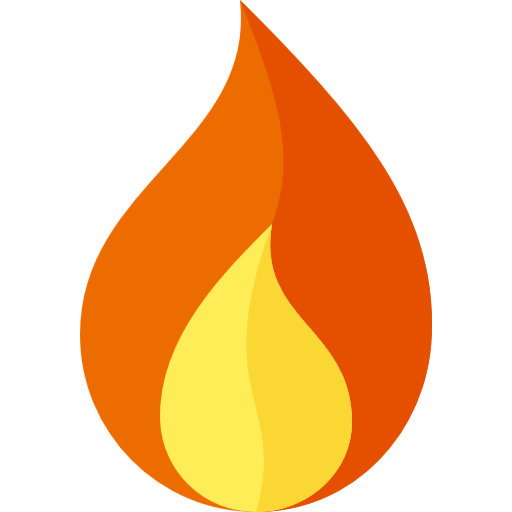
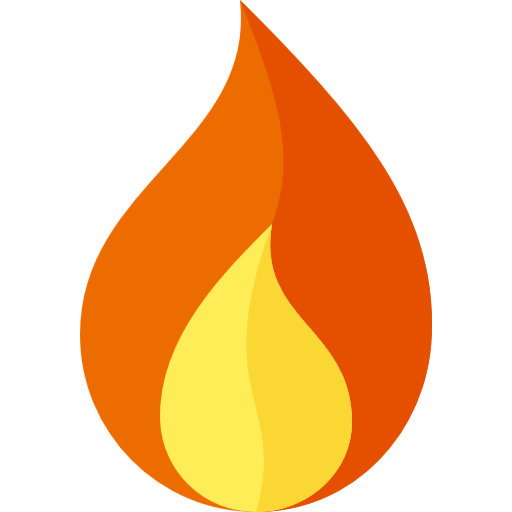
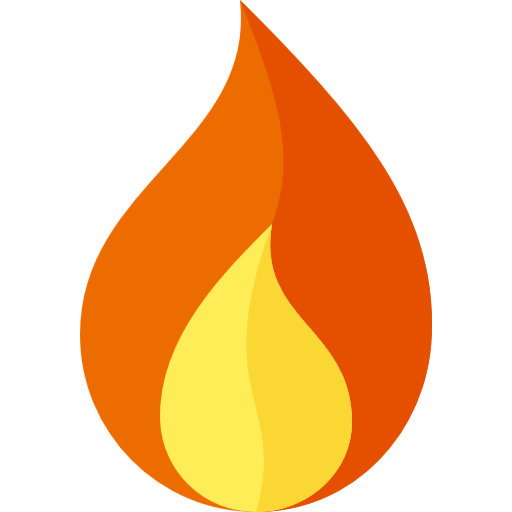

In [13]:
class PanelFoliumMapForecast(param.Parameterized):
    points_count = param.Integer(20, bounds=(10,100))
        
    def __init__(self, **params):
        super().__init__(**params)
        self.map = get_map()
        self.folium_pane = pn.pane.plot.Folium(sizing_mode="stretch_both", min_height=500, margin=0)    
        self.view = pn.Column(
            self.param.points_count,
            self.folium_pane,
            sizing_mode="stretch_both", height=500
        )
        self._update_map()

    @param.depends("points_count", watch=True)
    def _update_map(self):
        self.map = get_map()
        df_aqi = get_df_aqi()
        add_aqi_circles(self.map, df_aqi)
        self.folium_pane.object = self.map

        
app = PanelFoliumMapForecast()
app.view

## Creating Dashboard

In [31]:
#Layout using Template
template = pn.template.FastListTemplate(
    title='Amrabad Forest Fire Forecast', 
    sidebar=[pn.pane.Markdown("# CO2 Emissions and Climate Change"), 
             pn.pane.Markdown("#### Carbon dioxide emissions are the primary driver of global climate change. It’s widely recognised that to avoid the worst impacts of climate change, the world needs to urgently reduce emissions. But, how this responsibility is shared between regions, countries, and individuals has been an endless point of contention in international discussions."), 
             pn.pane.PNG('fire-flame.png', sizing_mode='scale_both'),
             pn.pane.Markdown("## Settings"),   
             year_slider],
    main=[pn.pane.Markdown("# Forest Fire Forecast"),
          pn.Row(pn.Column(PanelFoliumMapForecast().view), 
                 co2_table.panel(width=500)),
          pn.Row(pn.Column(co2_vs_gdp_scatterplot.panel(width=600), margin=(0,25)), 
                 pn.Column(yaxis_co2_source, co2_source_bar_plot.panel(width=600))),
          pn.pane.Markdown("# Forest Fire Active "),
          pn.Row(pn.Column(yaxis_co2,
                           PanelFoliumMap().view), 
                 co2_table.panel(width=500)),
          ],
    accent_base_color="#88d8b0", 
)
#template.show()
template.servable();